# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#Importing Libraries
#for math and data structure
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
#for modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import itertools
#for visualizations
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
zillow_data = pd.read_csv("zillow_data.csv")
zillow_data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Data Preprocessing

In [4]:
df = zillow_data.groupby('State').get_group('TX')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


# Reshape from Wide to Long Format

In [5]:
def melt_data(df): 
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='Month', value_name='MeanValue')
    
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [6]:
df = melt_data(zillow_data)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [7]:
def make_datetimeindex(df,col_to_make_index = 'Month',drop=False,verbose=True):

    df[col_to_make_index] = pd.to_datetime(df[col_to_make_index],errors='coerce')
    df = df.set_index('Month',drop=drop)
    
    if verbose:
        display(df.index)
    return df

In [8]:
df = make_datetimeindex(df)

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=3744704, freq=None)

In [10]:
#putting time series to the dataset

In [11]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [12]:
df = df.rename({'Month':'MonthOrig'},axis=1)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MonthOrig,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [13]:
df_city =  df.groupby('City').get_group('El Paso')
df_county = df.groupby('CountyName').get_group('El Paso')

display(df_city.head(20),df_city.index,df_county.head())

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MonthOrig,MeanValue
Month,,,,,,,,,
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,93123,79912,El Paso,TX,El Paso,El Paso,26,1996-04-01,119700.0
1996-04-01,93146,79938,El Paso,TX,El Paso,El Paso,179,1996-04-01,98400.0
1996-04-01,93133,79924,El Paso,TX,El Paso,El Paso,491,1996-04-01,61700.0
1996-04-01,93119,79907,El Paso,TX,El Paso,El Paso,1136,1996-04-01,58900.0
1996-04-01,93134,79925,El Paso,TX,El Paso,El Paso,1636,1996-04-01,81600.0
1996-04-01,93126,79915,El Paso,TX,El Paso,El Paso,2711,1996-04-01,57600.0
1996-04-01,93116,79904,El Paso,TX,El Paso,El Paso,3179,1996-04-01,60100.0
1996-04-01,93114,79902,El Paso,TX,El Paso,El Paso,4328,1996-04-01,101900.0


DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=4828, freq=None)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MonthOrig,MeanValue
Month,,,,,,,,,
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,93123,79912,El Paso,TX,El Paso,El Paso,26,1996-04-01,119700.0
1996-04-01,93146,79938,El Paso,TX,El Paso,El Paso,179,1996-04-01,98400.0
1996-04-01,93133,79924,El Paso,TX,El Paso,El Paso,491,1996-04-01,61700.0
1996-04-01,93596,80918,Colorado Springs,CO,Colorado Springs,El Paso,791,1996-04-01,128200.0


In [14]:
# checking number of zipcode in El paso
print(f"[i] There are {df_city['RegionName'].nunique()} zipcodes in El Paso")
display(df_city.head())
df_city.index

[i] There are 19 zipcodes in El Paso


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MonthOrig,MeanValue
Month,,,,,,,,,
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,93123,79912,El Paso,TX,El Paso,El Paso,26,1996-04-01,119700.0
1996-04-01,93146,79938,El Paso,TX,El Paso,El Paso,179,1996-04-01,98400.0
1996-04-01,93133,79924,El Paso,TX,El Paso,El Paso,491,1996-04-01,61700.0
1996-04-01,93119,79907,El Paso,TX,El Paso,El Paso,1136,1996-04-01,58900.0


DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=4828, freq=None)

Make El Paso ( dict of Zipcodes dfs)

# EDA and Visualization

In [15]:
El_P = {}
for zipcode in df_city['RegionName'].unique():
    temp = df_city.groupby("RegionName").get_group(zipcode)
    El_P[zipcode]=temp.resample('MS').asfreq()
El_P

{79936:             RegionID  RegionName     City State    Metro CountyName  SizeRank  \
 Month                                                                           
 1996-04-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 1996-05-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 1996-06-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 1996-07-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 1996-08-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 ...              ...         ...      ...   ...      ...        ...       ...   
 2017-12-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 2018-01-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 2018-02-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 2018-03-01     93144       79936  El Paso    TX  El Paso    El Paso         5   
 2018-04-

[79936, 79912, 79938, 79924, 79907, 79925, 79915, 79904, 79902, 79934, 79930, 79932, 79905, 79903, 79935, 79901, 79922, 79911, 79836]


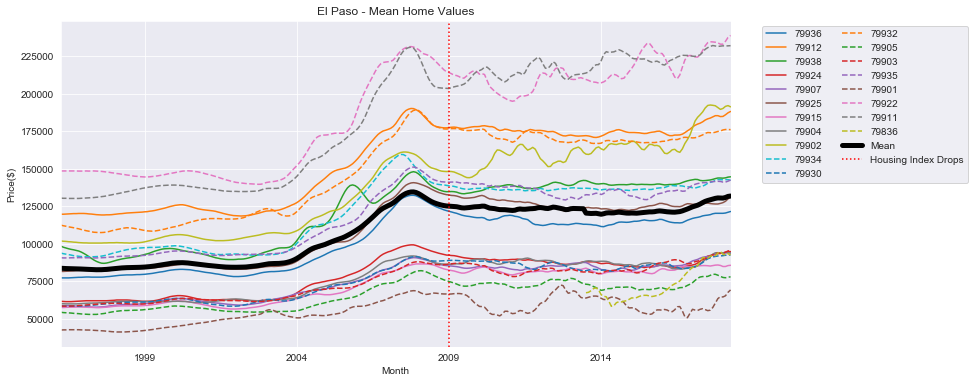

In [16]:
#Visualing all the zipcodes
def plot_ts_dict(df_dict,col='MeanValue',zipcodes=[]):
    
    if len(zipcodes)==0:
        zipcodes=list(df_dict.keys())
        
    print(zipcodes)
    
    cutoff = len(zipcodes)//2
    
        
    fig,ax = plt.subplots(figsize=(12,6))
    
    ts_dict = {}
    for i,zc in enumerate(zipcodes):
        if i <cutoff:
            ls='-'
        else:
            ls='--'
            
        ts = df_dict[zc][col].rename(zc)#.loc[zc]
        ts.plot(label=str(zc),ax=ax,ls=ls)
        ts_dict[zc] = ts

    ## CALCULTE MEAN   
    mean = pd.DataFrame(ts_dict).mean(axis=1)
    mean.plot(label='Mean',lw=5,color='black')

    crash = '01-2009'
    ax.axvline(crash, label='Housing Index Drops',color='red',ls=':')

    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
    ax.set(title='El Paso - Mean Home Values',
          ylabel='Price($)')

    return fig,ax,ts_dict
fig,ax,tsdict = plot_ts_dict(El_P)

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

In [18]:
# plotting acf and pacf
def plot_acf_pacf(ts, figsize=(10,8),lags=12):
    fig,ax = plt.subplots(nrows=3,figsize=figsize)
    ts.plot(ax=ax[0])
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    plt.tight_layout()
    
    plt.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    

In [19]:
zips = list(tsdict.keys())
zips

[79936,
 79912,
 79938,
 79924,
 79907,
 79925,
 79915,
 79904,
 79902,
 79934,
 79930,
 79932,
 79905,
 79903,
 79935,
 79901,
 79922,
 79911,
 79836]

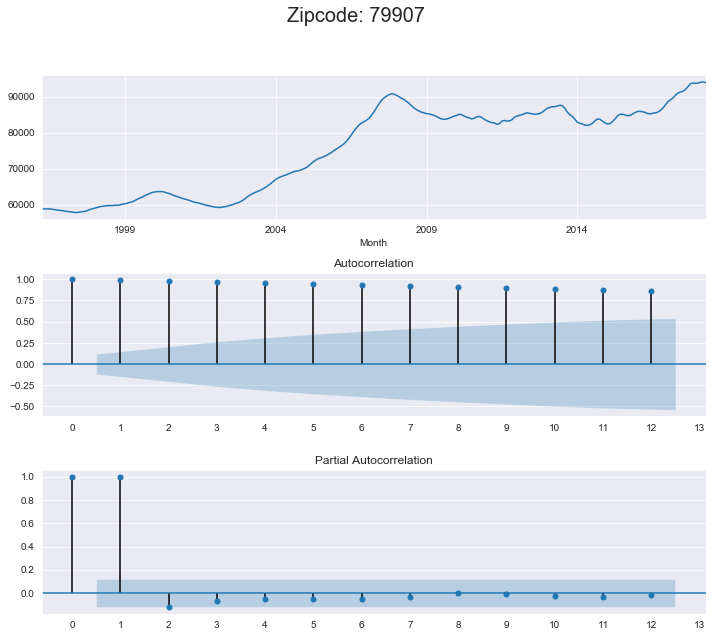

In [20]:
# viewing autocorr and partial corr
import matplotlib as mpl
ts = tsdict[79907]
ts = ts.rename(79907)
plot_acf_pacf(ts)

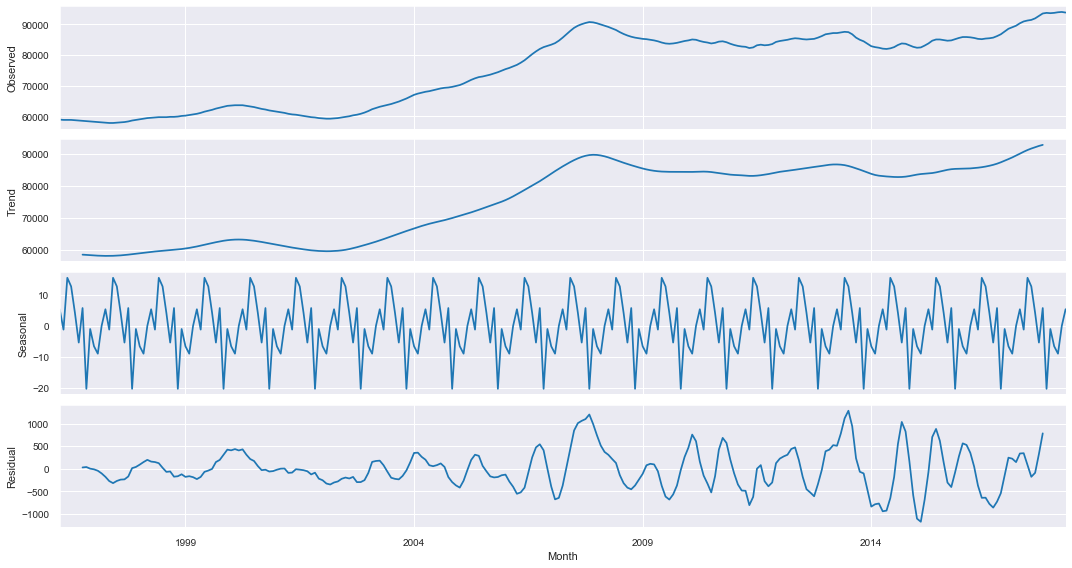

In [21]:
# Decomposing 
plt.style.use('seaborn-notebook')
mpl.rcParams['figure.figsize']=(15,8)

decomp = seasonal_decompose(ts)
decomp.plot();
plt.tight_layout()


# ARIMA Modeling

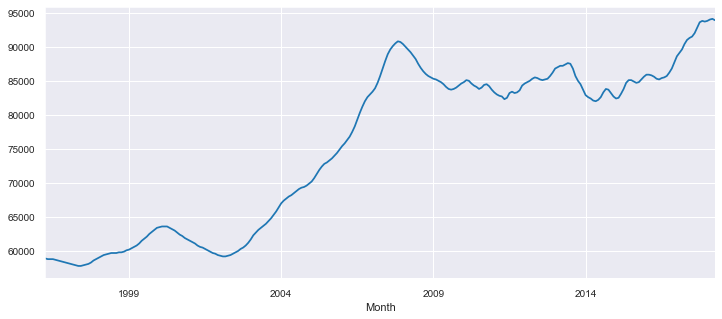

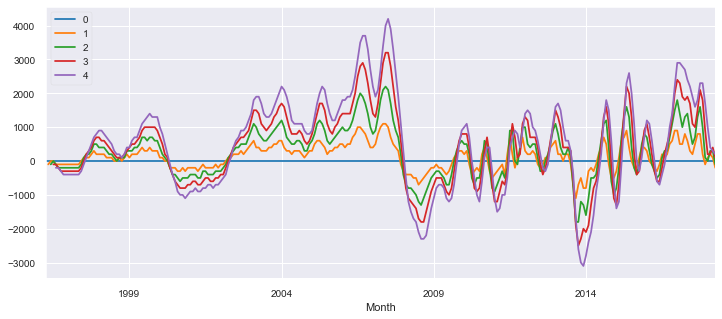

In [22]:
mpl.rcParams['figure.figsize']=(12,5)
ts.plot( )
plt.figure()
for i in range(5):
    ax = ts.diff(i).plot(label=i)
#     ax.set
ax.legend()

In [23]:
def make_pdq_pdqm(ps=[0,1,3],ds=[0,1,2,3], 
                  qs=[0,1,3],make_seasonal=True,
                  m_values=[12]):
    import itertools
#    ps =range(p_range[0],p_range[1])
#    ds =range(d_range[0],d_range[1])
#    qs =range(q_range[0],q_range[1])
    
    params = {}
    params['pdq'] = list(itertools.product(ps,ds,qs))
    
    if make_seasonal:
        params['PDQm'] = list(itertools.product(ps,ds,qs,m_values))
    return params

# fs.ihelp(ji.get_train_test_split_index,0)
def get_train_test_split_index(ts, TEST_SIZE=0.1,min_test_ts=2):
    import math
    idx_split = math.floor(len(ts.index)*(1-TEST_SIZE))
    
    num_test_ts=len(ts.iloc[idx_split:])
    if num_test_ts<min_test_ts:
        print(f'[!] Warning: using TEST_SIZE={TEST_SIZE} produced {num_test_ts} test timestamps.')
        print("- Overriding TEST_SIZE and using min_test_ts instead.")
        idx_split = len(ts)-min_test_ts
    
    return idx_split


def train_test_split_ts(ts,test_size=0.2,min_test_ts=2):
    idx_split = get_train_test_split_index(ts,TEST_SIZE=test_size,
                                           min_test_ts=min_test_ts)
    ts_train = ts.iloc[:idx_split]
    ts_test = ts.iloc[idx_split:]
    return ts_train, ts_test

def get_now(return_dt = True, return_str=True, show=False):
    import datetime as dt
    import tzlocal as tz
    now=dt.datetime.now(tz=tz.get_localzone())
    str_time =now.strftime('%m/%d/%Y - %I:%M:%S %p')
    if show:
        print(str_time)
    
    output=[]
    if return_dt:
        output.append(now)
        
    if return_str:
        output.append(str_time)
    return output[:]


In [24]:
#setting up the parameters
params = make_pdq_pdqm()
print(params.keys())
print(params['pdq'][:10])
params['PDQm'][:10]

dict_keys(['pdq', 'PDQm'])
[(0, 0, 0), (0, 0, 1), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 3), (0, 3, 0)]


[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 3, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 3, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 3, 12),
 (0, 3, 0, 12)]

New Grid Search Functions

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def grid_search_arima_optional_s(ts_train,pdq=None,pdqm=None,order_dict=None,
                                 make_seasonal=False, verbose=False, model_kws={}):

    from tqdm import trange
    
    if (pdq is None) & (order_dict is not None):
        pdq= order_dict['pdq']
    if (pdqm is None) & (order_dict is not None):
        pdqm= order_dict['PDQm']

    import tqdm
    from tqdm import trange

    start,start_str = get_now(return_dt=True, return_str=True)
    print(f'[i] STARTING GRID SEARCH @ {start_str}:')
    
    
    res = [['pdq','PDQM','AIC']]
    for i in trange((len(pdq))):
        comb = pdq[i]
        
     
        ## BRANCH POINT
        if make_seasonal:
            for combs in pdqm:
                try: 
                    model = SARIMAX(ts_train, order=comb, 
                                   seasonal_order =combs,enforce_stationarity=False,
                                   enforce_invertibility=False,**model_kws)

                    output= model.fit()
                    res.append([comb,combs,output.aic])
                except:
                    if verbose:
                        print(f"[!] Error running ({comb})({combs})")
                    continue
                    
                    
        if make_seasonal == False:
            try: 
                model = SARIMAX(ts_train, order=comb, 
                                enforce_stationarity=False, 
                                enforce_invertibility=False,**model_kws)

                output= model.fit()
                res.append([comb,'N/A',output.aic])
            except:
                if verbose:
                    print(f"[!] Error running ({comb})({combs})")
                    continue
                    
    end,end_str = get_now(return_dt=True, return_str=True)
    elapsed = end-start
    print(f"[i] GRID SEARCH FINISHED AT {end_str}")
    print(f"\tTotal Time: {elapsed}")

    try:
        df_res =fs.list2df(res)
        return df_res
    
    except:
        print('Error converting to df. Returning as list.')
        return res 

### Def grid search

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def grid_search (ts_train,pdq=None,pdqm=None,order_dict=None,
                                 make_seasonal=False, verbose=False, model_kws={}):

    from tqdm import trange
    
    if (pdq is None) & (order_dict is not None):
        pdq= order_dict['pdq']
    if (pdqm is None) & (order_dict is not None):
        pdqm= order_dict['PDQm']

    import tqdm
    from tqdm import trange

    start,start_str = get_now(return_dt=True, return_str=True)
    print(f'[i] STARTING GRID SEARCH @ {start_str}:')
    
    
    res = [['pdq','PDQM','AIC']]
    for i in trange((len(pdq))):
        comb = pdq[i]
        
     
        ## BRANCH POINT
        if make_seasonal:
            for combs in pdqm:
                try: 
                    model = SARIMAX(ts_train, order=comb, 
                                   seasonal_order =combs,enforce_stationarity=False,
                                   enforce_invertibility=False,**model_kws)

                    output= model.fit()
                    res.append([comb,combs,output.aic])
                except:
                    if verbose:
                        print(f"[!] Error running ({comb})({combs})")
                    continue
                    
                    
        if make_seasonal == False:
            try: 
                model = SARIMAX(ts_train, order=comb, 
                                enforce_stationarity=False, 
                                enforce_invertibility=False,**model_kws)

                output= model.fit()
                res.append([comb,'N/A',output.aic])
            except:
                if verbose:
                    print(f"[!] Error running ({comb})({combs})")
                    continue
                    
    end,end_str = get_now(return_dt=True, return_str=True)
    elapsed = end-start
    print(f"[i] GRID SEARCH FINISHED AT {end_str}")
    print(f"\tTotal Time: {elapsed}")

    
    res = pd.DataFrame(res[1:], columns= res[0]) 
    res.sort_values('AIC',inplace=True)
    return res

Testing on Single Zipcode

In [27]:
ts = tsdict[79902]
ts_train,ts_test = train_test_split_ts(ts,test_size=0.1)

len(ts_train),len(ts_test)

(238, 27)

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
res2 = grid_search(ts_train,order_dict=params,make_seasonal=False)#pdq,pdqm)

[i] STARTING GRID SEARCH @ 01/20/2020 - 02:22:28 PM:


100%|██████████| 36/36 [00:18<00:00,  1.90it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:22:47 PM
	Total Time: 0:00:18.921126


In [30]:
res = grid_search_arima_optional_s(ts_train,order_dict=params,make_seasonal=False)#pdq,pdqm)
#res.sort_values('AIC',inplace=True)
#res.head()

[i] STARTING GRID SEARCH @ 01/20/2020 - 02:23:12 PM:


100%|██████████| 36/36 [00:18<00:00,  1.94it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:23:31 PM
	Total Time: 0:00:18.585742
Error converting to df. Returning as list.


In [31]:
res

[['pdq', 'PDQM', 'AIC'],
 [(0, 0, 0), 'N/A', 6273.626636411676],
 [(0, 0, 1), 'N/A', 6077.051738077508],
 [(0, 0, 3), 'N/A', 7718.296188028495],
 [(0, 1, 0), 'N/A', 3978.750872348042],
 [(0, 1, 1), 'N/A', 3751.5663738189733],
 [(0, 1, 3), 'N/A', 3600.847958479597],
 [(0, 2, 0), 'N/A', 3762.1040306001582],
 [(0, 2, 1), 'N/A', 3690.5422227752038],
 [(0, 2, 3), 'N/A', 3605.698505999345],
 [(0, 3, 0), 'N/A', 3816.6277105438894],
 [(0, 3, 1), 'N/A', 3801.544961983911],
 [(0, 3, 3), 'N/A', 3648.7067203722054],
 [(1, 0, 0), 'N/A', 3984.390325774295],
 [(1, 0, 1), 'N/A', 3778.5132020569727],
 [(1, 0, 3), 'N/A', 3622.086513073532],
 [(1, 1, 0), 'N/A', 3754.4480556783374],
 [(1, 1, 1), 'N/A', 3672.766189416059],
 [(1, 1, 3), 'N/A', 3601.1875766375974],
 [(1, 2, 0), 'N/A', 3738.9088669496923],
 [(1, 2, 1), 'N/A', 3681.113955710487],
 [(1, 2, 3), 'N/A', 3594.8997931393696],
 [(1, 3, 0), 'N/A', 3818.570341409789],
 [(1, 3, 1), 'N/A', 3759.312805125344],
 [(1, 3, 3), 'N/A', 3642.621781265245],
 [(3,

In [32]:
# changing for list to dataframe
res = pd.DataFrame(res[1:], columns= res[0])

In [33]:
res.sort_values('AIC',inplace=True)
res.head()

,pdq,PDQM,AIC
32,"(3, 2, 3)",N/A,3584.953585
20,"(1, 2, 3)",N/A,3594.899793
29,"(3, 1, 3)",N/A,3597.873615
5,"(0, 1, 3)",N/A,3600.847958
17,"(1, 1, 3)",N/A,3601.187577


In [34]:
# Getting the best params
best_params =  dict(order=res.iloc[0].loc['pdq'])
best_params

{'order': (3, 2, 3)}

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  79902   No. Observations:                  238
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1785.477
Date:                Mon, 20 Jan 2020   AIC                           3584.954
Time:                        14:24:35   BIC                           3609.081
Sample:                    04-01-1996   HQIC                          3594.684
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0157      0.072      0.219      0.827      -0.125       0.156
ar.L2          0.1459      0.070      2.073      0.038       0.008       0.284
ar.L3          0.1551      0.050      3.110      0.002       0.057       0.253
ma.L1          0.4709      0.370      1.273      0.203      -0.254       1.196
ma.L2         -0.6901      0.516     -1.337      0.181      -1.702       0.321
ma.L3         -0.7791      0.276     -2.820      0.005      -1.320      -0.238
sigma2      2.741e+05   9.35e+04      2.931      0.003    9.08e+04    4.57e+05
===================================================================================
Ljung-Box (Q):                      132.25   Jarque-Bera (JB):                57.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.71   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

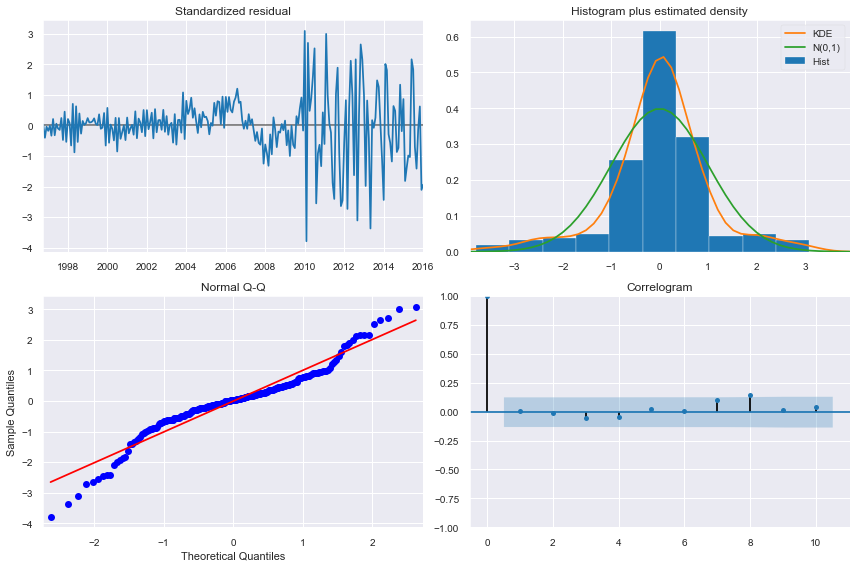

In [35]:
#getting model summary
model_output = SARIMAX(ts_train,**best_params,
                      enforce_invertibility=False,
                      enforce_stationarity=False).fit()
display(model_output.summary())
model_output.plot_diagnostics(figsize=(12,8));
plt.tight_layout()

In [36]:
#viewing training data
ts_train

Month
1996-04-01    101900.0
1996-05-01    101700.0
1996-06-01    101600.0
1996-07-01    101400.0
1996-08-01    101300.0
                ...   
2015-09-01    166100.0
2015-10-01    165400.0
2015-11-01    165500.0
2015-12-01    164900.0
2016-01-01    162600.0
Freq: MS, Name: 79902, Length: 238, dtype: float64

def ROI and model evaluation functions

In [37]:
#Evaluating the model
def model_evaluation(ts_true,ts_pred,show=True,show_u_info=False):
    from sklearn.metrics import mean_squared_error,r2_score

    res= [['Metric','Value']]
    
    res.append(['RMSE', np.sqrt(mean_squared_error(ts_true,ts_pred))])
    
    res.append(['R2',r2_score(ts_true,ts_pred)])
    #res.append(["Thiel's U",fs.jmi.thiels_U(ts_true,ts_pred,
    #                                       display_equation=show_u_info,
     #                                      display_table=show_u_info)])
    #res = fs.list2df(res)
    
    if show:
        display(res)
    return res
    
def expected_roi(investment, final_value):
    """This function takes in a series of forecasts to predict the return
    on investment spanning the entire forecast."""
    roi = np.round(((final_value - investment) / investment)*100,3)
    return roi

In [38]:
ts_train.name

79902

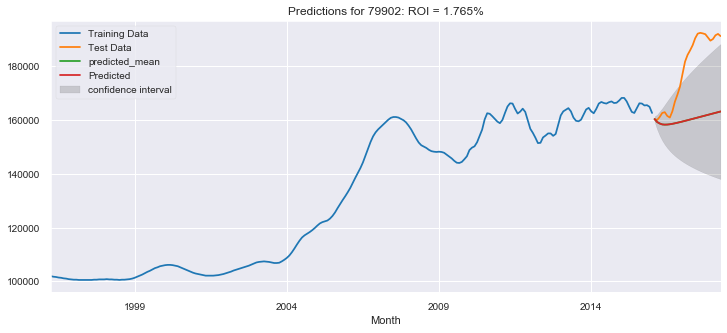

[['Metric', 'Value'], ['RMSE', 21720.77784422017], ['R2', -1.798481011853569]]

,lower 79902,upper 79902,predicted_mean
2016-02-01,159289.145752,161345.362522,160317.254137
2016-03-01,156474.100100,161992.138744,159233.119422
2016-04-01,154203.016041,163189.659557,158696.337799
2016-05-01,152357.078052,164334.428811,158345.753432
2016-06-01,150855.571128,165672.229729,158263.900428
2016-07-01,149580.981390,167015.719456,158298.350423
2016-08-01,148482.589343,168322.866987,158402.728165
2016-09-01,147525.912546,169607.813792,158566.863169
2016-10-01,146672.983668,170847.383003,158760.183336
2016-11-01,145903.654563,172043.405436,158973.529999


In [40]:
def model_predictions(model_output,ts_train,ts_test,start=None,end=None, get_metrics=True):
    
    if start is None:
        start=ts_test.index[0]
        
    if end is None:
        end=ts_test.index[-1] 
        
        
        #make a function
    # Get predictions starting from 2016 and calculate confidence intervals.   
    prediction = model_output.get_prediction(start=start,end=end, 
                                             dynamic=True)
    
    
    preds_df = prediction.conf_int()
    preds_df['predicted_mean'] = prediction.predicted_mean
    plot_df = pd.concat([preds_df,ts_train],axis=1)

    
    
    
    ## Get roi for preds:
    roi = expected_roi(preds_df['predicted_mean'].iloc[0],preds_df['predicted_mean'].iloc[-1])
    
    zc =ts_train.name
    
    
    
    
    
    # make a function    
    fig, ax = plt.subplots()
    ts_train.plot(ax=ax,label='Training Data')
    ts_test.plot(ax=ax,label='Test Data')

    
    preds_df['predicted_mean'].plot(ax=ax)
    ax.fill_between(preds_df.index, preds_df[f'lower {zc}'],
                preds_df[f'upper {zc}'], color="k", alpha=.15,
                label = 'confidence interval')

    prediction.predicted_mean.plot(ax=ax,label='Predicted')
    
    
    ax.legend()
    ax.set(title=f"Predictions for {zc}: ROI = {roi}%")
    
    fig = ax.get_figure()
    
    
    plot_df['zipcode']=ts_train.name
    plt.show()
    
    if get_metrics:
        res = model_evaluation(ts_test, preds_df['predicted_mean'])
#         res['Metric']

    return preds_df, fig,ax

preds_df,fig,ax = model_predictions(model_output,ts_train,ts_test)
preds_df

In [41]:
tsdict

{79936: Month
 1996-04-01     77300.0
 1996-05-01     77300.0
 1996-06-01     77300.0
 1996-07-01     77300.0
 1996-08-01     77400.0
                 ...   
 2017-12-01    120300.0
 2018-01-01    120300.0
 2018-02-01    120500.0
 2018-03-01    121000.0
 2018-04-01    121500.0
 Freq: MS, Name: 79936, Length: 265, dtype: float64, 79912: Month
 1996-04-01    119700.0
 1996-05-01    119700.0
 1996-06-01    119800.0
 1996-07-01    119900.0
 1996-08-01    120000.0
                 ...   
 2017-12-01    184700.0
 2018-01-01    184800.0
 2018-02-01    185900.0
 2018-03-01    187200.0
 2018-04-01    188100.0
 Freq: MS, Name: 79912, Length: 265, dtype: float64, 79938: Month
 1996-04-01     98400.0
 1996-05-01     97700.0
 1996-06-01     97200.0
 1996-07-01     96700.0
 1996-08-01     96300.0
                 ...   
 2017-12-01    143800.0
 2018-01-01    143700.0
 2018-02-01    143900.0
 2018-03-01    144400.0
 2018-04-01    144600.0
 Freq: MS, Name: 79938, Length: 265, dtype: float64, 79924: Mo

# Meta grid search

In [43]:
#fig,ax,tsdict = plot_ts_dict(El_P)

In [44]:
print(ts.index[0])
ts.index[0]+ pd.to_timedelta(1,'MS')
end=ts.index[0]+ pd.to_timedelta(1,'MS')
pd.to_datetime(end)

1996-04-01 00:00:00


Timestamp('1996-04-01 00:00:00.001000', freq='MS')



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79936
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:27:59 PM:


100%|██████████| 36/36 [00:18<00:00,  1.94it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:28:18 PM
	Total Time: 0:00:18.574752
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


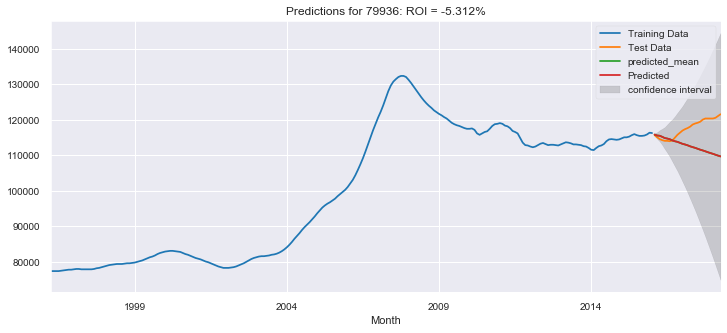

[['Metric', 'Value'], ['RMSE', 6458.835771285215], ['R2', -5.433818204788865]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79912
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:28:20 PM:


100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:28:41 PM
	Total Time: 0:00:20.601725
Error converting to df. Returning as list.
Best params:  {'order': (1, 2, 3)}


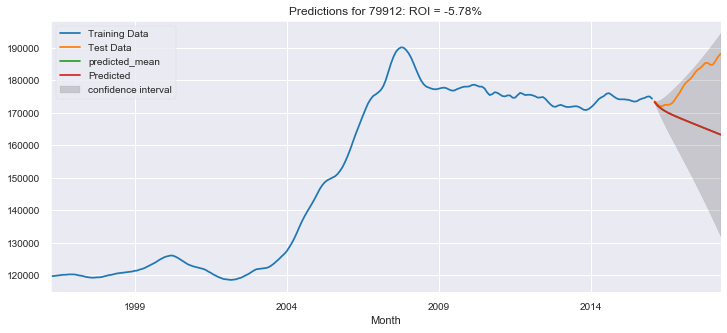

[['Metric', 'Value'], ['RMSE', 14246.037190807747], ['R2', -5.735929267300027]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79938
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:28:43 PM:


100%|██████████| 36/36 [00:17<00:00,  2.10it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:29:00 PM
	Total Time: 0:00:17.148746
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


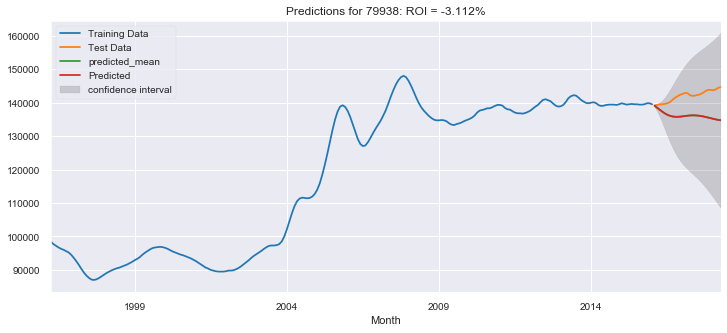

[['Metric', 'Value'], ['RMSE', 6359.565125172879], ['R2', -13.718460645463079]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79924
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:29:05 PM:


100%|██████████| 36/36 [00:19<00:00,  1.84it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:29:24 PM
	Total Time: 0:00:19.546705
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


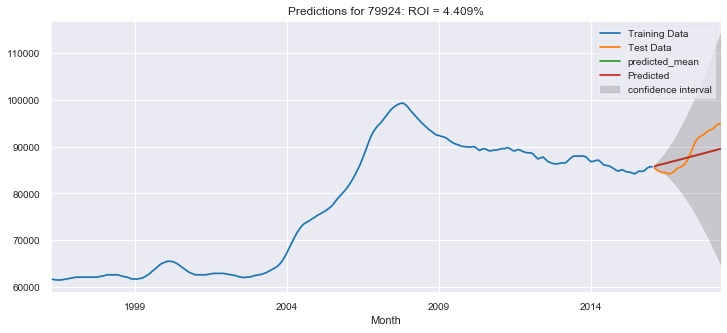

[['Metric', 'Value'], ['RMSE', 3112.07131943006], ['R2', 0.3851470715777441]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79907
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:29:28 PM:


100%|██████████| 36/36 [00:22<00:00,  1.59it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:29:51 PM
	Total Time: 0:00:22.685069
Error converting to df. Returning as list.
Best params:  {'order': (1, 2, 3)}


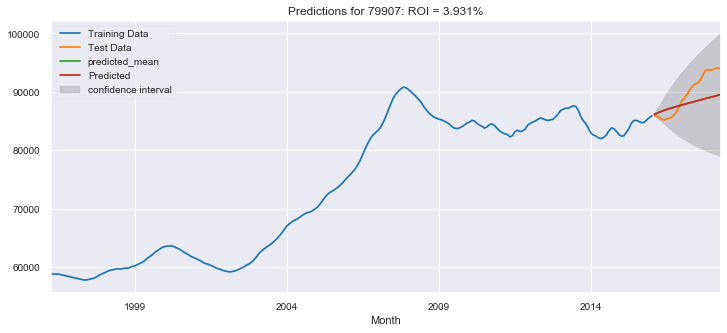

[['Metric', 'Value'],
 ['RMSE', 2929.5309346084873],
 ['R2', 0.24561111337948272]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79925
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:29:54 PM:


100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:30:14 PM
	Total Time: 0:00:20.678243
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


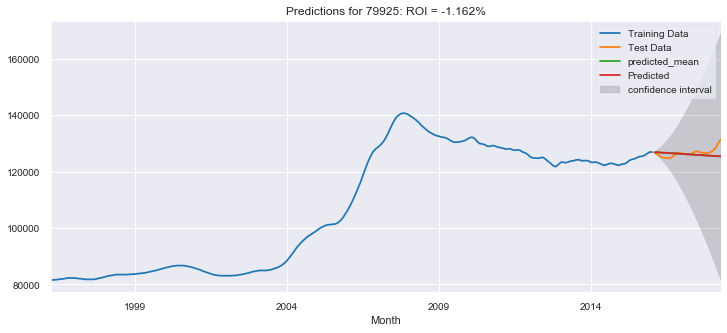

[['Metric', 'Value'], ['RMSE', 1825.013043542626], ['R2', -0.6943896245878747]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79915
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:30:17 PM:


100%|██████████| 36/36 [00:20<00:00,  1.71it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:30:38 PM
	Total Time: 0:00:21.009776
Error converting to df. Returning as list.
Best params:  {'order': (3, 1, 3)}


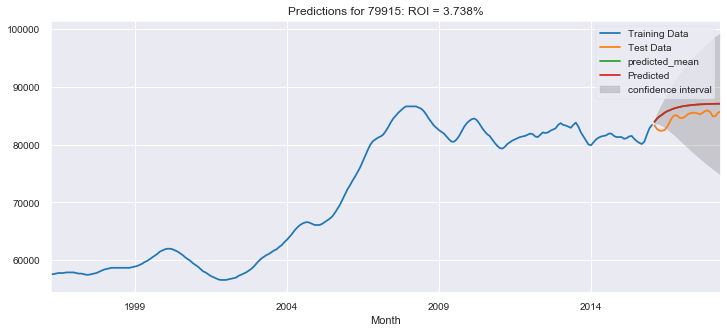

[['Metric', 'Value'], ['RMSE', 1805.4747950178278], ['R2', -1.641445358853722]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79904
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:30:40 PM:


100%|██████████| 36/36 [00:21<00:00,  1.64it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:31:02 PM
	Total Time: 0:00:22.001707
Error converting to df. Returning as list.
Best params:  {'order': (3, 1, 3)}


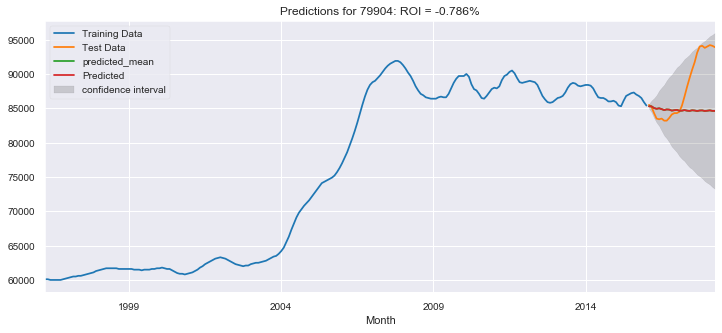

[['Metric', 'Value'], ['RMSE', 5523.300713195617], ['R2', -0.5842939195749008]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79902
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:31:05 PM:


100%|██████████| 36/36 [00:19<00:00,  1.89it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:31:25 PM
	Total Time: 0:00:19.112267
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


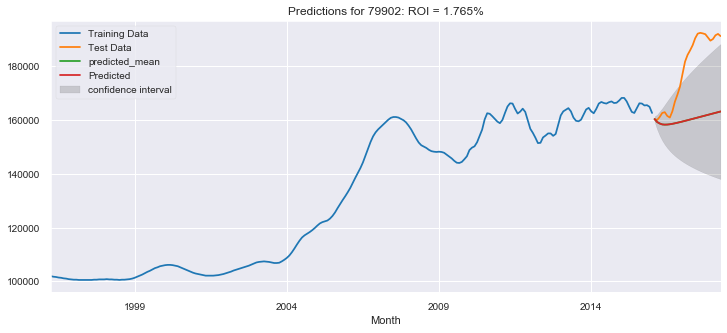

[['Metric', 'Value'], ['RMSE', 21720.77784422017], ['R2', -1.798481011853569]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79934
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:31:28 PM:


100%|██████████| 36/36 [00:13<00:00,  2.66it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:31:41 PM
	Total Time: 0:00:13.550821
Error converting to df. Returning as list.
Best params:  {'order': (1, 3, 3)}


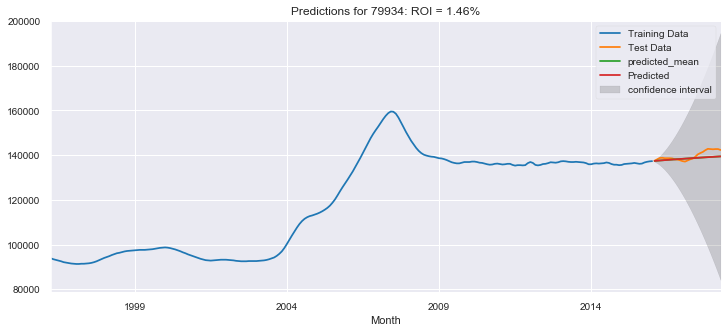

[['Metric', 'Value'],
 ['RMSE', 1934.5848845434946],
 ['R2', 0.061448567443227575]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79930
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:31:44 PM:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:32:05 PM
	Total Time: 0:00:20.505702
Error converting to df. Returning as list.
Best params:  {'order': (1, 2, 3)}


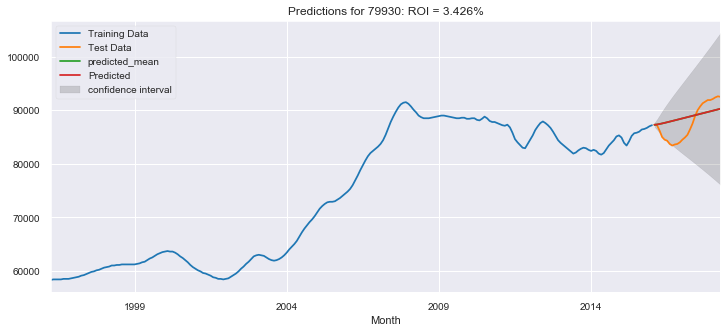

[['Metric', 'Value'],
 ['RMSE', 2837.3975126300625],
 ['R2', 0.28850326759860934]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79932
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:32:07 PM:


100%|██████████| 36/36 [00:20<00:00,  1.77it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:32:27 PM
	Total Time: 0:00:20.394258
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


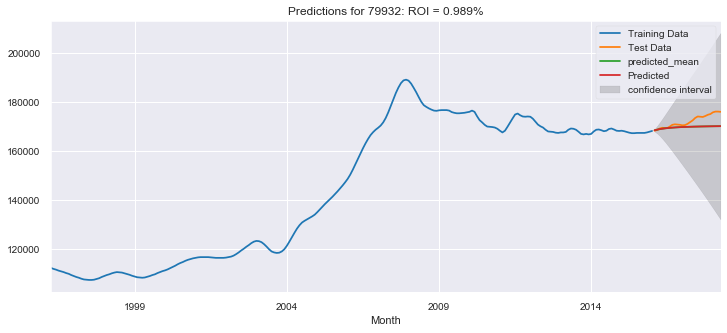

[['Metric', 'Value'],
 ['RMSE', 3226.1995689313335],
 ['R2', -0.6652102679847949]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79905
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:32:31 PM:


100%|██████████| 36/36 [00:19<00:00,  1.81it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:32:51 PM
	Total Time: 0:00:19.910711
Error converting to df. Returning as list.
Best params:  {'order': (3, 1, 3)}


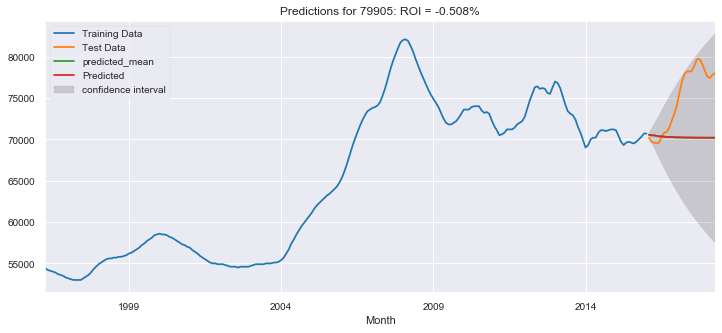

[['Metric', 'Value'], ['RMSE', 6045.598392556966], ['R2', -1.5820879358402795]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79903
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:32:53 PM:


100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:33:12 PM
	Total Time: 0:00:18.762763
Error converting to df. Returning as list.
Best params:  {'order': (3, 1, 3)}


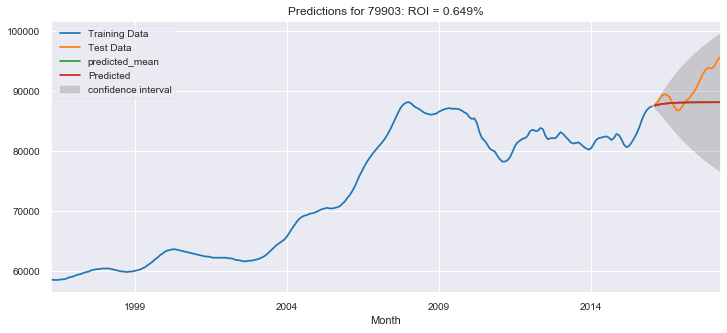

[['Metric', 'Value'],
 ['RMSE', 3524.6236310508184],
 ['R2', -0.6553607800643388]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79935
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:33:14 PM:


100%|██████████| 36/36 [00:15<00:00,  2.35it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:33:29 PM
	Total Time: 0:00:15.345795
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


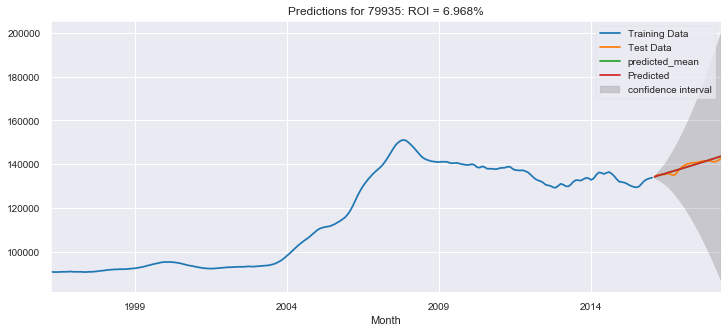

[['Metric', 'Value'], ['RMSE', 971.5350117651967], ['R2', 0.8791312761154493]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79901
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:33:32 PM:


100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:33:53 PM
	Total Time: 0:00:20.821722
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


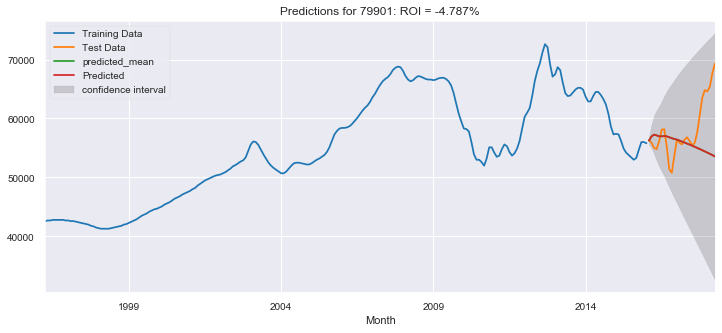

[['Metric', 'Value'], ['RMSE', 6075.958358471747], ['R2', -0.7028692035443775]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79922
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:33:59 PM:


100%|██████████| 36/36 [00:16<00:00,  2.14it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:34:15 PM
	Total Time: 0:00:16.847775
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


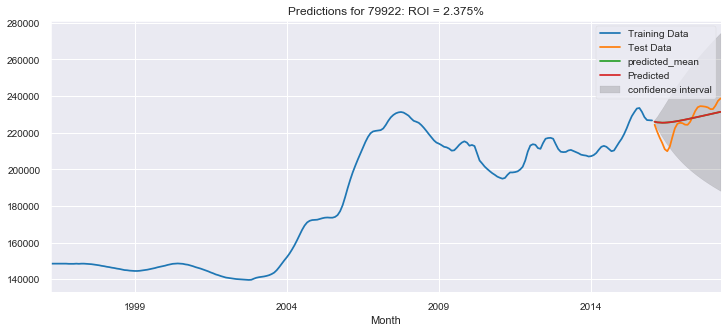

[['Metric', 'Value'], ['RMSE', 6725.257482541742], ['R2', 0.33598456197530246]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79911
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:34:18 PM:


100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:34:37 PM
	Total Time: 0:00:19.387747
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


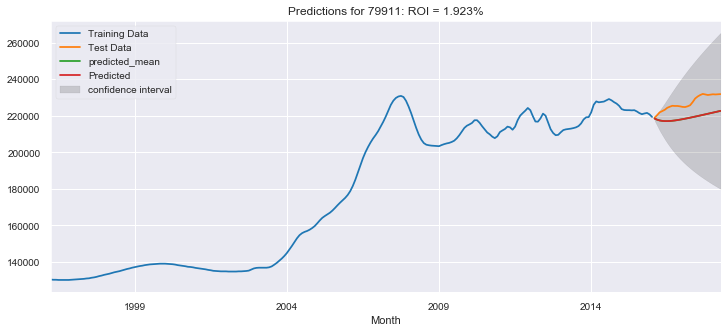

[['Metric', 'Value'], ['RMSE', 8287.617650303484], ['R2', -3.4127073016127865]]



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79836
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:34:40 PM:


100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:34:48 PM
	Total Time: 0:00:07.959893
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


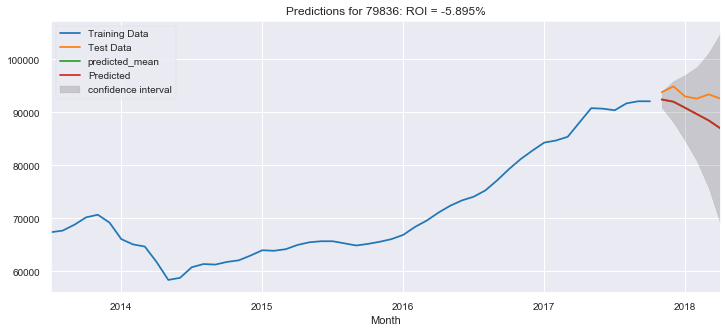

[['Metric', 'Value'],
 ['RMSE', 3630.4427998289184],
 ['R2', -19.549334656642138]]

In [45]:
params = make_pdq_pdqm()

ts_resdict = {}
for zc,ts in tsdict.items():
    print('\n')
    print('---'*30)
    print('---'*30)
    print(f'ZIPCODE: {zc}')
    ## Train test split
    ts_train,ts_test = train_test_split_ts(ts,test_size=0.1)
    

    ## Grid search
    res = grid_search_arima_optional_s(ts_train,order_dict=params,make_seasonal=False)#pdq,pdqm)
    res = pd.DataFrame(res[1:], columns= res[0])
    res.sort_values('AIC',inplace=True)
    best_params =  dict(order=res.iloc[0].loc['pdq'])
    
    ts_resdict[zc]={}
    ts_resdict[zc]['res']=res
    ts_resdict[zc]['best_params'] = best_params
    print('Best params: ',best_params)
    

    ## Using best params
    model_output = SARIMAX(ts_train,**best_params,
                      enforce_invertibility=False,
                      enforce_stationarity=False).fit()
    ts_resdict[zc]['model'] = model_output
    
    preds_df,fig,ax = model_predictions(model_output,ts_train,ts_test)
    ts_resdict[zc]['preds_df'] = preds_df

# Step 6: Interpreting Results



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79936
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:36:33 PM:


100%|██████████| 36/36 [00:18<00:00,  1.93it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:36:52 PM
	Total Time: 0:00:18.707236
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


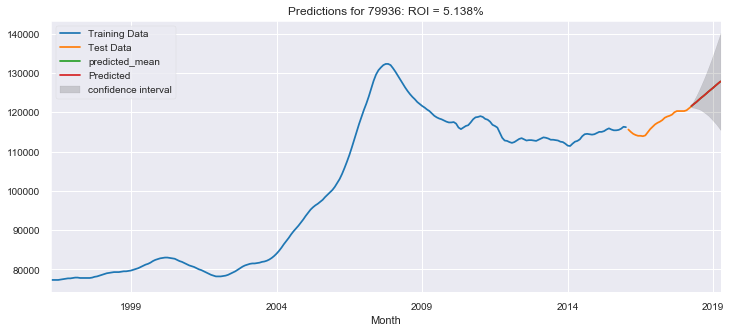



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79912
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:36:55 PM:


100%|██████████| 36/36 [00:20<00:00,  1.72it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:37:16 PM
	Total Time: 0:00:20.918236
Error converting to df. Returning as list.
Best params:  {'order': (1, 2, 3)}


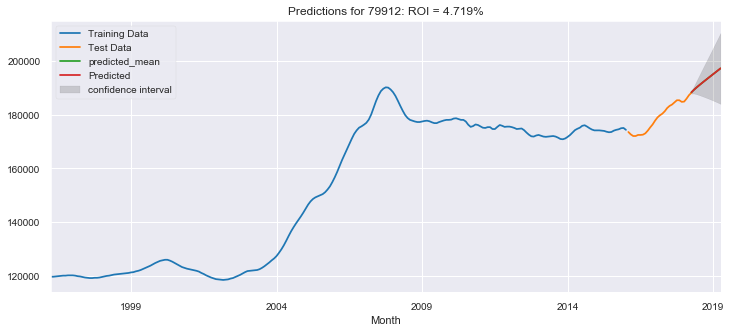



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79938
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:37:18 PM:


100%|██████████| 36/36 [00:17<00:00,  2.11it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:37:35 PM
	Total Time: 0:00:17.117873
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


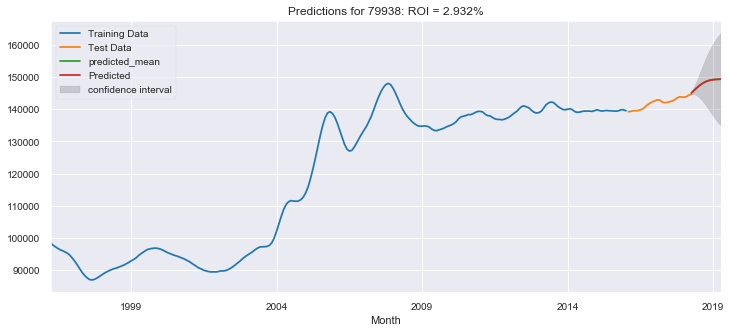



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79924
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:37:39 PM:


100%|██████████| 36/36 [00:18<00:00,  1.95it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:37:57 PM
	Total Time: 0:00:18.480754
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


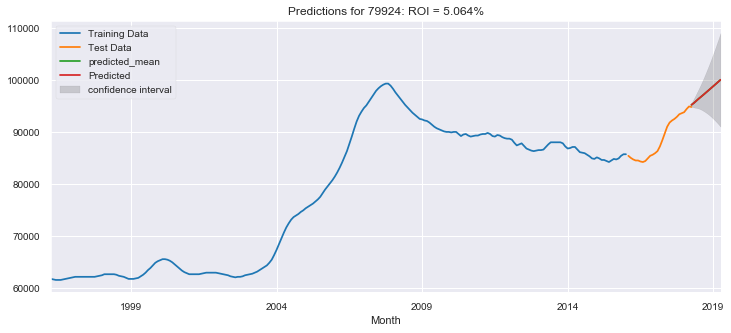



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79907
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:38:02 PM:


100%|██████████| 36/36 [00:21<00:00,  1.64it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:38:23 PM
	Total Time: 0:00:21.964088
Error converting to df. Returning as list.
Best params:  {'order': (1, 2, 3)}


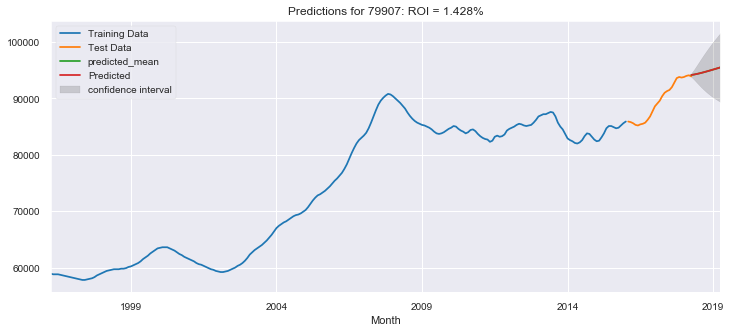



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79925
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:38:26 PM:


100%|██████████| 36/36 [00:21<00:00,  1.70it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:38:48 PM
	Total Time: 0:00:21.239245
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


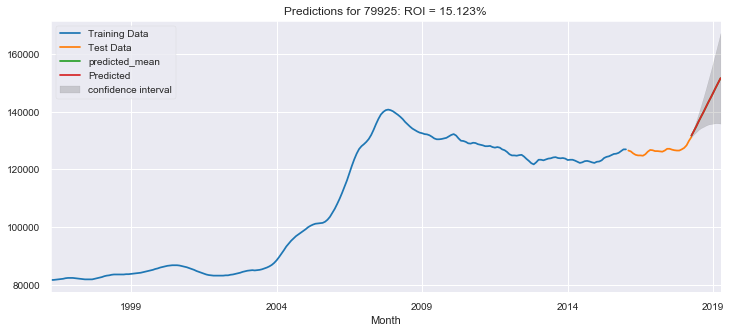



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79915
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:38:50 PM:


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:39:10 PM
	Total Time: 0:00:20.184726
Error converting to df. Returning as list.
Best params:  {'order': (3, 1, 3)}


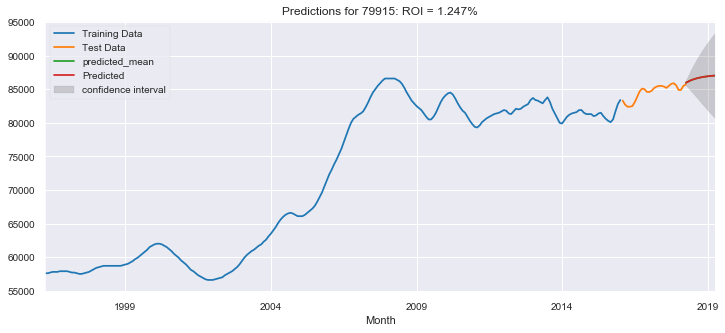



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79904
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:39:13 PM:


100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:39:34 PM
	Total Time: 0:00:21.293714
Error converting to df. Returning as list.
Best params:  {'order': (3, 1, 3)}


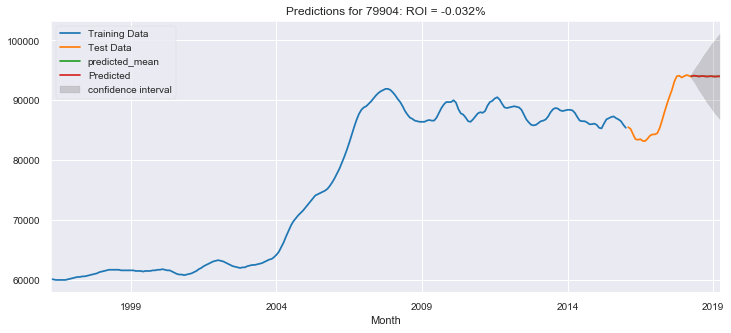



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79902
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:39:38 PM:


100%|██████████| 36/36 [00:18<00:00,  1.95it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:39:56 PM
	Total Time: 0:00:18.502752
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


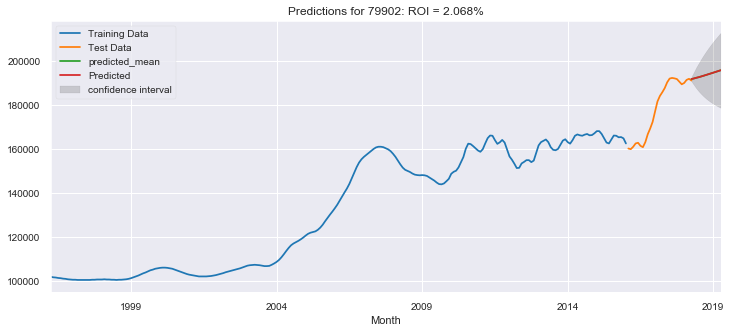



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79934
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:40:00 PM:


100%|██████████| 36/36 [00:13<00:00,  2.62it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:40:14 PM
	Total Time: 0:00:13.737817
Error converting to df. Returning as list.
Best params:  {'order': (1, 3, 3)}


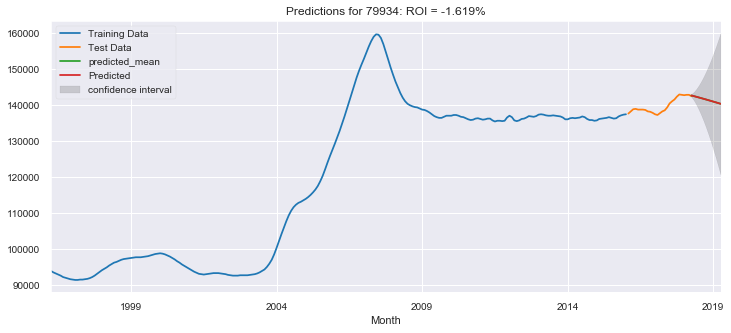



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79930
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:40:17 PM:


100%|██████████| 36/36 [00:19<00:00,  1.83it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:40:36 PM
	Total Time: 0:00:19.721737
Error converting to df. Returning as list.
Best params:  {'order': (1, 2, 3)}


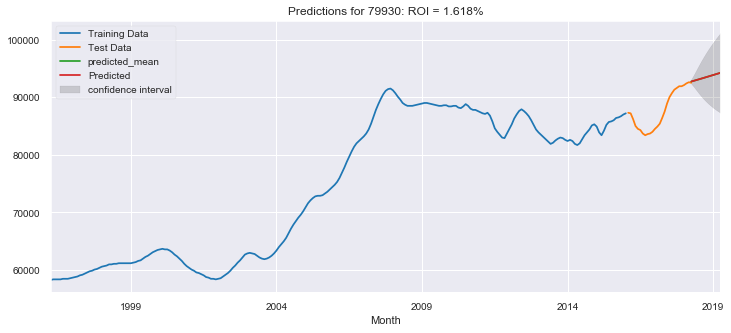



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79932
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:40:39 PM:


100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:40:58 PM
	Total Time: 0:00:19.393740
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


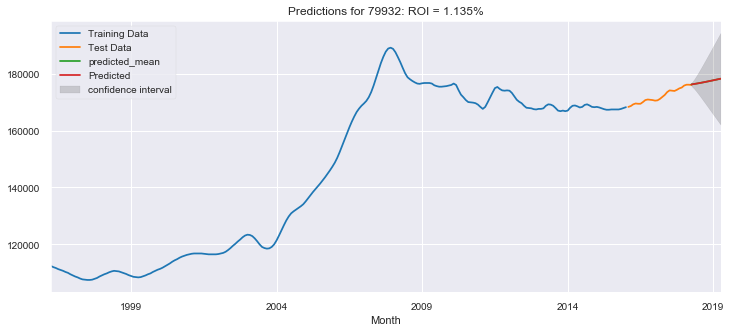



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79905
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:41:03 PM:


100%|██████████| 36/36 [00:20<00:00,  1.80it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:41:23 PM
	Total Time: 0:00:20.048730
Error converting to df. Returning as list.
Best params:  {'order': (3, 1, 3)}


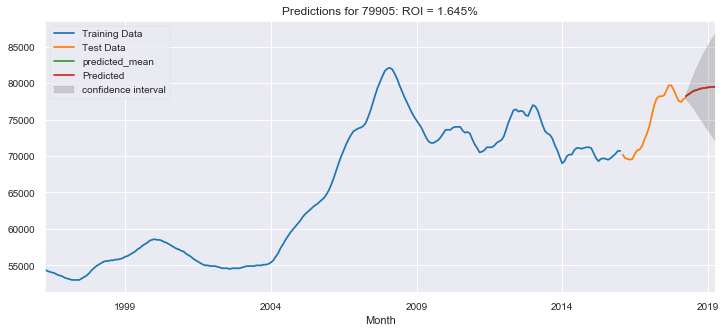



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79903
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:41:25 PM:


100%|██████████| 36/36 [00:18<00:00,  1.94it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:41:43 PM
	Total Time: 0:00:18.607730
Error converting to df. Returning as list.
Best params:  {'order': (3, 1, 3)}


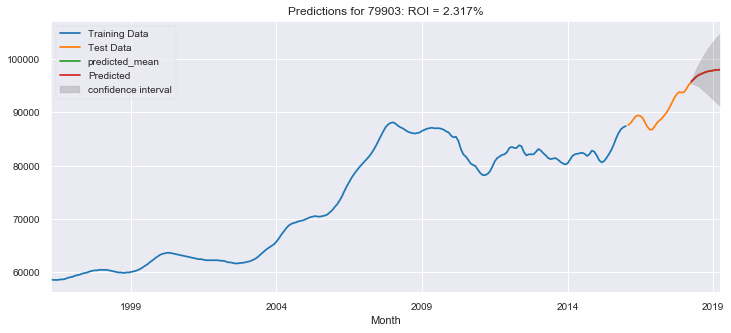



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79935
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:41:46 PM:


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:42:01 PM
	Total Time: 0:00:15.471798
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


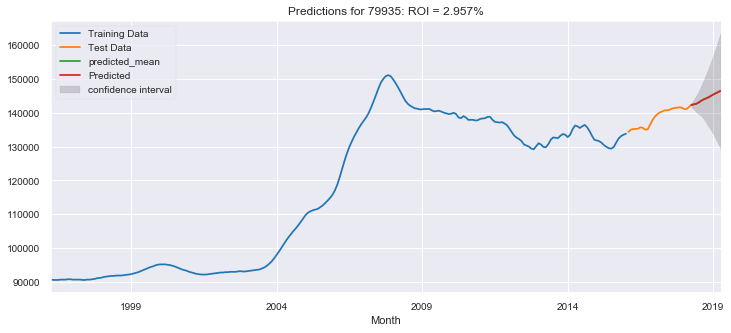



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79901
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:42:05 PM:


100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:42:26 PM
	Total Time: 0:00:21.263717
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


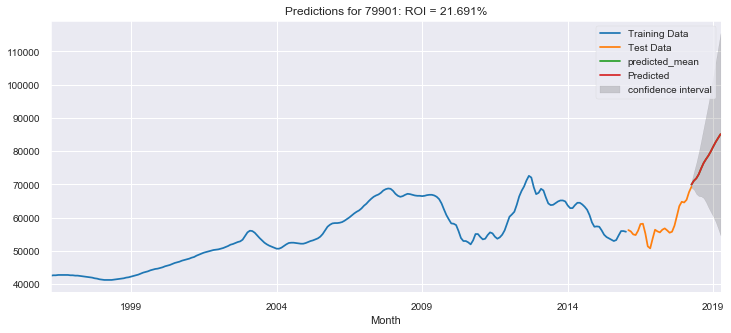



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79922
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:42:28 PM:


100%|██████████| 36/36 [00:16<00:00,  2.19it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:42:45 PM
	Total Time: 0:00:16.452787
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


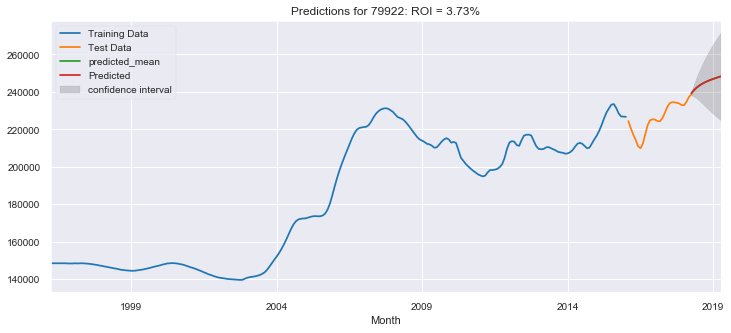



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79911
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:42:49 PM:


100%|██████████| 36/36 [00:19<00:00,  1.82it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:43:09 PM
	Total Time: 0:00:19.832263
Error converting to df. Returning as list.
Best params:  {'order': (3, 2, 3)}


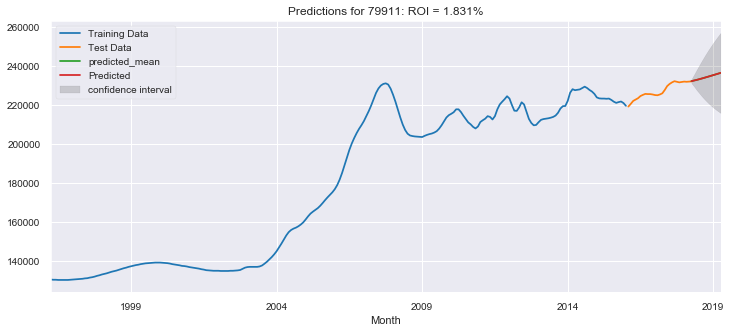



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
ZIPCODE: 79836
[i] STARTING GRID SEARCH @ 01/20/2020 - 02:43:12 PM:


100%|██████████| 36/36 [00:07<00:00,  4.54it/s]


[i] GRID SEARCH FINISHED AT 01/20/2020 - 02:43:20 PM
	Total Time: 0:00:07.945874
Error converting to df. Returning as list.
Best params:  {'order': (3, 3, 3)}


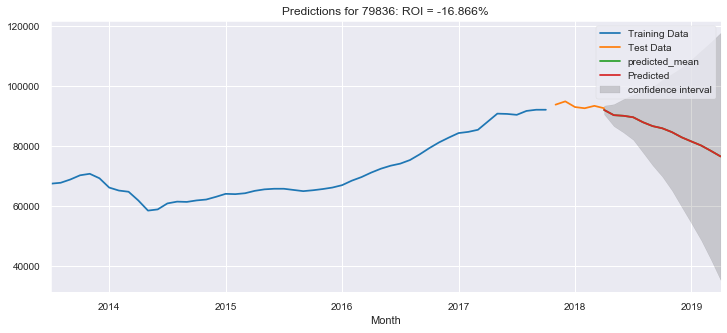

In [47]:
params = make_pdq_pdqm()

ts_resdict = {}
for zc,ts in tsdict.items():
    print('\n')
    print('---'*30)
    print('---'*30)
    print(f'ZIPCODE: {zc}')
    ## Train test split
    ts_train,ts_test = train_test_split_ts(ts,test_size=0.1)
    

    ## Grid search
    res = grid_search_arima_optional_s(ts_train,order_dict=params,make_seasonal=False)#pdq,pdqm)
    res = pd.DataFrame(res[1:], columns= res[0])
    res.sort_values('AIC',inplace=True)
    best_params =  dict(order=res.iloc[0].loc['pdq'])
    
    ts_resdict[zc]={}
    ts_resdict[zc]['res']=res
    ts_resdict[zc]['best_params'] = best_params
    print('Best params: ',best_params)
    

    ## Using best params
    model_output = SARIMAX(ts,**best_params,
                      enforce_invertibility=False,
                      enforce_stationarity=False).fit()
    ts_resdict[zc]['model'] = model_output
    
    preds_df,fig,ax = model_predictions(model_output,ts_train,ts_test,
                                         start=ts.index[-1],end=ts.index.shift(12)[-1],get_metrics=False)#+ pd.to_timedelta(1,'MS'))
    ts_resdict[zc]['preds_df'] = preds_df

# CONCLUSION

From our model, we come up with these 5 top zip codes with the highest ROI

# Best 5 zip codes to invest in the city of El paso

79901 = 21.691%
79925 = 15.123%
79936 = 5.138%
79924 = 5.064%
79912 = 4.719%
